# 2012 Hashtag Networks 

## Modules

In [1]:
# Utilities
import sys
#sys.path.insert(1, r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/")
sys.path.insert(1, r"E:\IlMIoDrive\magistrale\1anno\terzo_periodo\MAS\analysis")
from pathlib import Path 
import json as js
import bz2
import ast
import operator
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
from collections import OrderedDict
from collections import Counter
import pickle
import pandas as pd
import numpy as np
from copy import deepcopy

# Data Visualization
#import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import networkx as nx
%pylab inline

# Custom 
from datetime import datetime
from importlib import reload
import Econophysics as Ec
Ec=reload(Ec)

Populating the interactive namespace from numpy and matplotlib


## User

In [13]:
user ="Pietro"

## Data Collection

### Paths

In [16]:
# Pietro Monticone
if user=="Pietro":
    davide_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/Data/polarized_hashtags/hashtags_davide.txt"
    pietro_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/Data/polarized_hashtags/hashtags_pietro.txt"
    riccardo_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/Data/polarized_hashtags/hashtags_riccardo.txt"
    claudio_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/Data/polarized_hashtags/hashtags_claudio.txt"
    survived_users_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/Data/AT_thread_output/survived_users.txt"
    saved_objects_path=r"/Volumes/PITHD2/ArchiveTeam/2012/SavedObjects/"
    opinion_dict_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/opinion_dict.txt"
    hashtag_dict_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/hashtag_dict.txt"
    cooccurence_matrix_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/cooccurence_matrix.txt"
    hashtag_collection_path=r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/hashtag_collection.txt"
# Claudio Moroni
elif user=="Claudio":
    davide_path=r"E:\IlMIoDrive\magistrale\1anno\terzo_periodo\MAS\temp\hashtags\polarized_hashtags\splits\text_files\hashtags_davide.txt"
    pietro_path=r"E:\IlMIoDrive\magistrale\1anno\terzo_periodo\MAS\temp\hashtags\polarized_hashtags\splits\text_files\hashtags_pietro.txt"
    riccardo_path=r"E:\IlMIoDrive\magistrale\1anno\terzo_periodo\MAS\temp\hashtags\polarized_hashtags\splits\text_files\hashtags_riccardo.txt"
    claudio_path=r"E:\IlMIoDrive\magistrale\1anno\terzo_periodo\MAS\temp\hashtags\polarized_hashtags\splits\text_files\hashtags_claudio.txt"
    survived_users_path=r"D:\TwitterUsers\archiveTeam\final_analysis\AT_thread_output\ok_users.txt"
    saved_objects_path=r"F:\TwitterUsers\archiveTeam\saved_objs\\"
    opinion_dict_path=r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\opinion_dict.txt"
    hashtag_dict_path=r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\hashtag_dict.txt"
    cooccurence_matrix_path=r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\cooccurence_matrix.txt"
    hashtag_collection_path=r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\hashtag_collection.txt"

### Load 

In [20]:
# Load hashtags labelled by Davide Orsenigo
file=open(davide_path, "r")
contents=file.read()
hashtags=ast.literal_eval(contents)
file.close()
# Load hashtags labelled by Pietro Monticone
file=open(pietro_path, "r")
contents=file.read()
hashtags+=ast.literal_eval(contents)
file.close()
# Load hashtags labelled by Riccardo Roma
file=open(riccardo_path, "r")
contents=file.read()
hashtags+=ast.literal_eval(contents)
file.close()
# Load hashtags labelled by Claudio Moroni
file=open(claudio_path, "r")
contents=file.read()
hashtags+=ast.literal_eval(contents)[:1000]
file.close()

# Load 2020-survived users (circa 160,000)
with open(survived_users_path,"rb") as f:
    survived_users=set(pickle.load(f))
    f.close()
    
# Load opinion and hashtag dictionaries
with open(opinion_dict_path, "rb") as f:
    opinion_dict=pickle.load(f)
    f.close()
with open(hashtag_dict_path, "rb") as f:
    hashtag_dict=pickle.load(f)
    f.close()
with open(cooccurence_matrix_path, "rb") as f:
    cooccurence_matrix=pickle.load(f)
    f.close()
with open(hashtag_collection_path, "rb") as f:
    hashtag_collection=pickle.load(f)
    f.close()
    
# Create list of hashtags 
hashtag_list=[h['hashtag'] for h in hashtags]
# Create dictionary of polarities
polarity_dict={h['hashtag']:h['polarity'] for h in hashtags}
# Initialize polarized hashtag lists
positive_hashtags=[]
negative_hashtags=[]
neutral_hashtags=[]
# Populate polarized hashtag lists
for hashtag in hashtags:
    if hashtag['polarity']==1:
        positive_hashtags.append(hashtag['hashtag'])
    elif hashtag['polarity']==-1:
        negative_hashtags.append(hashtag['hashtag'])
    elif hashtag['polarity']==0:
        neutral_hashtags.append(hashtag['hashtag'])
# Polarity rates 
positive_rate=len(positive_hashtags)/len(hashtag_list)
negative_rate=len(negative_hashtags)/len(hashtag_list)
neutral_rate=len(neutral_hashtags)/len(hashtag_list)
print("Positive rate: ",positive_rate,"\nNegative rate: ",negative_rate,"\nNeutral rate: ",neutral_rate)

Positive rate:  0.3431009499275479 
Negative rate:  0.248108195137659 
Neutral rate:  0.4084688455965223


## Data Wrangling 

In [12]:
%%time
day=0 
tweets=[]
hashtag_collection=[]
cooccurence_matrix=OrderedDict((hashtag, OrderedDict((hashtag, 0) for hashtag in hashtag_list)) for hashtag in hashtag_list)
            
# Initialize opinion dictionary
opinion_dict={}
for user in survived_users:
    opinion_dict[user]=0
# Initialize hashtag occurence dictionary
hashtag_dict={}
for hashtag in hashtag_list:
    hashtag_dict[hashtag]=0
    
# Fill opinion and hashtag dictionaries
for month in range(8,12):
    for day in range(31):
        path=saved_objects_path+str(month)+"\objs_"+str(day)+".txt"
        if Path(path).is_file():
            with open(path,"rb") as f: 
                tweets=pickle.load(f)
                f.close()
            relevant_tweets=[tweet for tweet in tweets if tweet["user_id"] in survived_users]
            for tweet in relevant_tweets:
                #opinion_dict[tweet["user_id"]]+=len(set(tweet['hashtags']).intersection(set(positive_hashtags)))
                #opinion_dict[tweet["user_id"]]-=len(set(tweet['hashtags']).intersection(set(negative_hashtags)))
                hashtags=list( set(tweet['hashtags']).intersection(set(hashtag_list)) )
                hashtag_collection.append(hashtags)
                if len(hashtags)>0:
                    for hashtag in hashtags:
                        hashtag_dict[hashtag]+=1
        print(path, end="\r")

# Populate the co-occurence matrix
for occurence in hashtag_collection:
    for i in range(len(occurence)):
        for hashtag in occurence[:i]+occurence[i+1:]:
            cooccurence_matrix[occurence[i]][hashtag]+= 1

Wall time: 22.4 s


In [21]:
# Create co-occurrence dictionary
cooccurrence_dict={} 
for key,value in cooccurence_matrix.items():
    cooccurrence_dict[key]=sum([num for k, num in value.items()])

# Create joint distribution
occurrence_coccurrence_distribution={key:cooccurrence_dict[key]+hashtag_dict[key] for key,value in cooccurrence_dict.items()}

## Data Storage 

In [ ]:
#### Save opinion and hashtag dictionaries

# with open(r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/opinion_dict.txt", "wb") as f:
#     pickle.dump(opinion_dict,f)
#     f.close()

# with open(r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/hashtag_dict.txt", "wb") as f:
#     pickle.dump(hashtag_dict,f)
#     f.close()


# with open(r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/cooccurence_matrix.txt", "wb") as f:
#     pickle.dump(cooccurence_matrix,f)
#     f.close()

# with open(r"/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/Output/hashtag_collection.txt", "wb") as f:
#     pickle.dump(hashtag_collection,f)
#     f.close()

## Descriptive Statistics

### Occurence Distribution

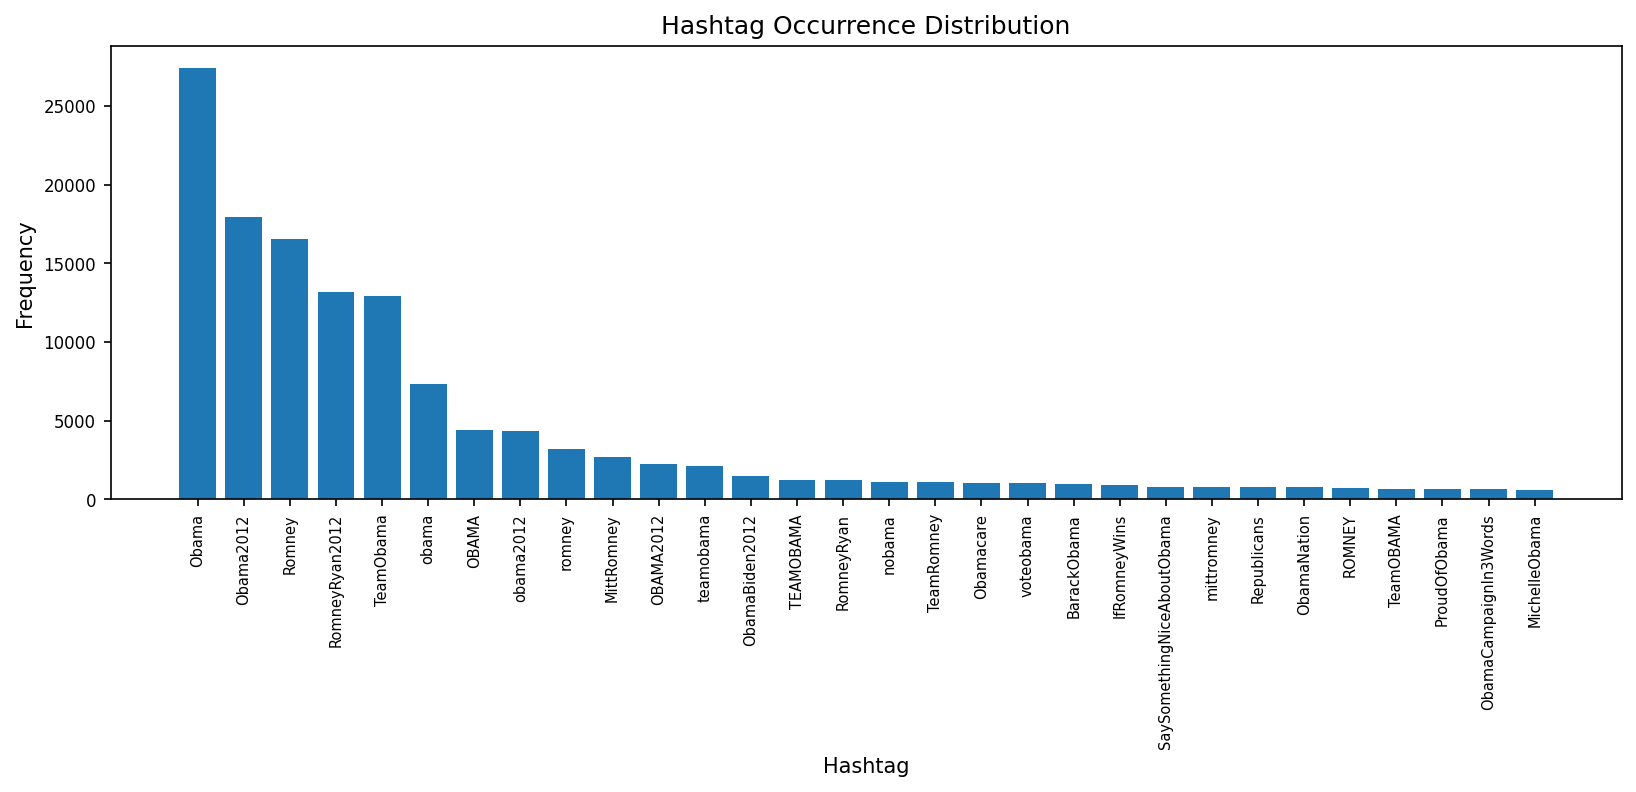

In [65]:
# Plot occurrence distribution
hashtag_names_occurrence=[hashtag[0] for hashtag in sorted(hashtag_dict.items(), key=operator.itemgetter(1), reverse=True)]
hashtag_occurences_occurrence=[hashtag[1] for hashtag in sorted(hashtag_dict.items(), key=operator.itemgetter(1), reverse=True)]
plt.figure(figsize=(13,4), dpi=150)
plt.ylabel("Frequency", fontsize=10)
plt.xlabel("Hashtag", fontsize=10)
plt.xticks(size=7, rotation=90)
plt.yticks(size=8)
plt.title("Hashtag Occurrence Distribution")
plt.bar(hashtag_names_occurrence[:30],hashtag_occurences_occurrence[:30])
plt.show()

### Co-occurrence Distribution

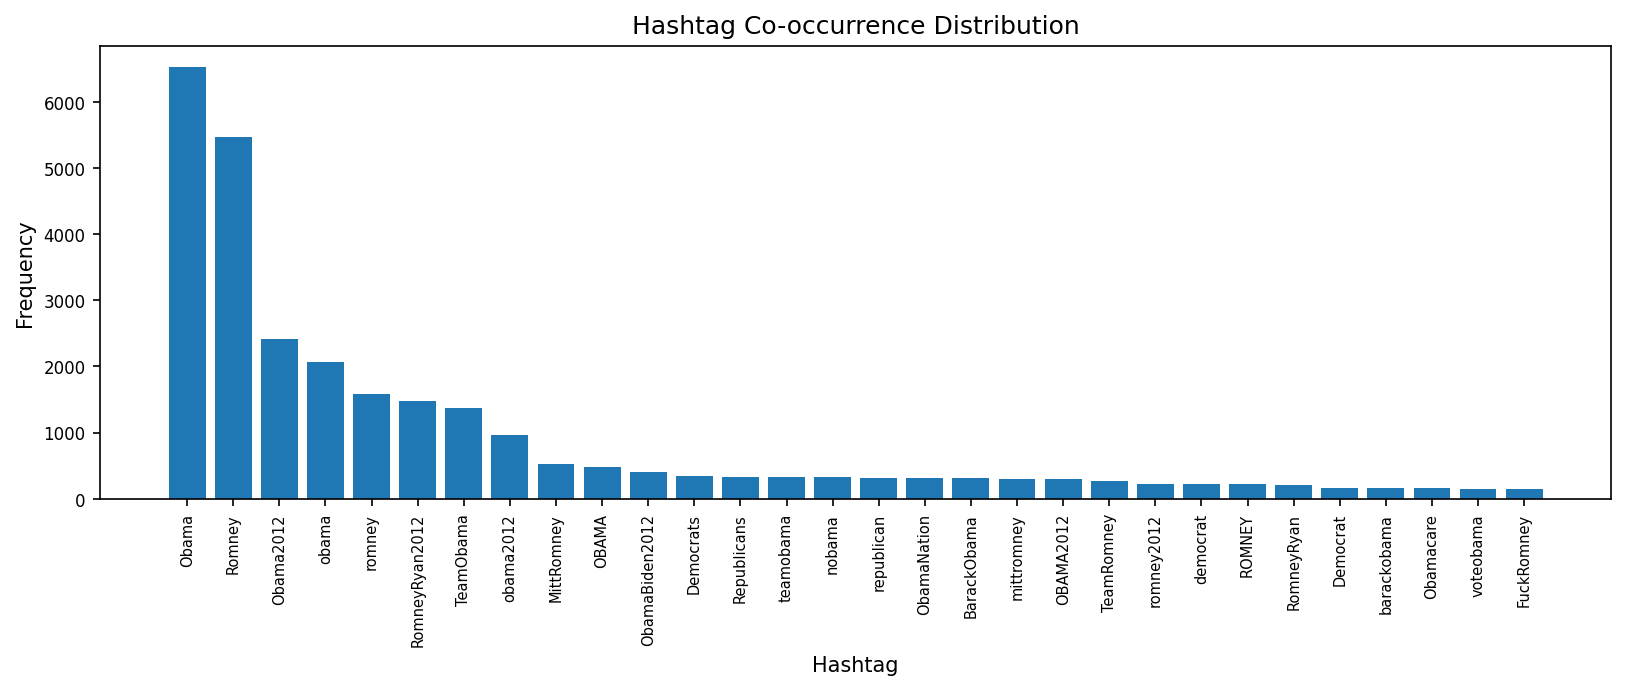

In [67]:
# Plot co-occurrence distribution
hashtag_names_cooccurrence=[hashtag[0] for hashtag in sorted(cooccurrence_dict.items(), key=operator.itemgetter(1), reverse=True)]
hashtag_occurences_cooccurrence=[hashtag[1] for hashtag in sorted(cooccurrence_dict.items(), key=operator.itemgetter(1), reverse=True)]
plt.figure(figsize=(13,4), dpi=150)
plt.ylabel("Frequency", fontsize=10)
plt.xlabel("Hashtag", fontsize=10)
plt.xticks(size=7, rotation=90)
plt.yticks(size=8)
plt.title("Hashtag Co-occurrence Distribution")
plt.bar(hashtag_names_cooccurrence[:30],hashtag_occurences_cooccurrence[:30])
plt.show()

### Occurrence Co-occurrence Distribution

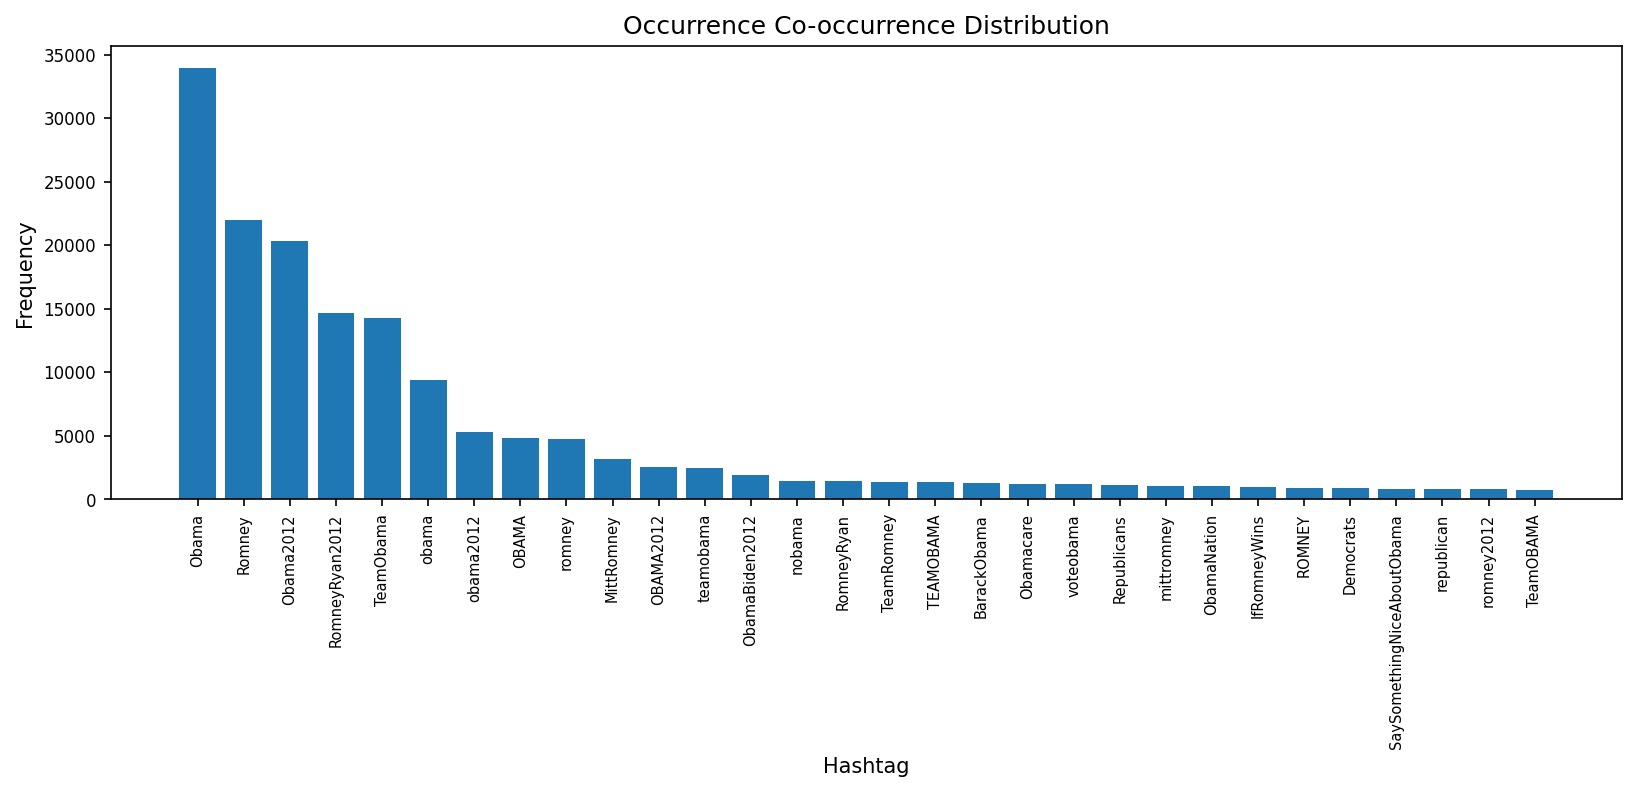

In [68]:
# Plot joint distribution
hashtag_names_joint=[hashtag[0] for hashtag in sorted(occurrence_coccurrence_distribution.items(), key=operator.itemgetter(1), reverse=True)]
hashtag_occurences_joint=[hashtag[1] for hashtag in sorted(occurrence_coccurrence_distribution.items(), key=operator.itemgetter(1), reverse=True)]
plt.figure(figsize=(13,4), dpi=150)
plt.ylabel("Frequency", fontsize=10)
plt.xlabel("Hashtag", fontsize=10)
plt.xticks(size=7, rotation=90)
plt.yticks(size=8)
plt.title("Occurrence Co-occurrence Distribution")
plt.bar(hashtag_names_joint[:30],hashtag_occurences_joint[:30])
plt.show()

### Aggregated Opinion Distribution

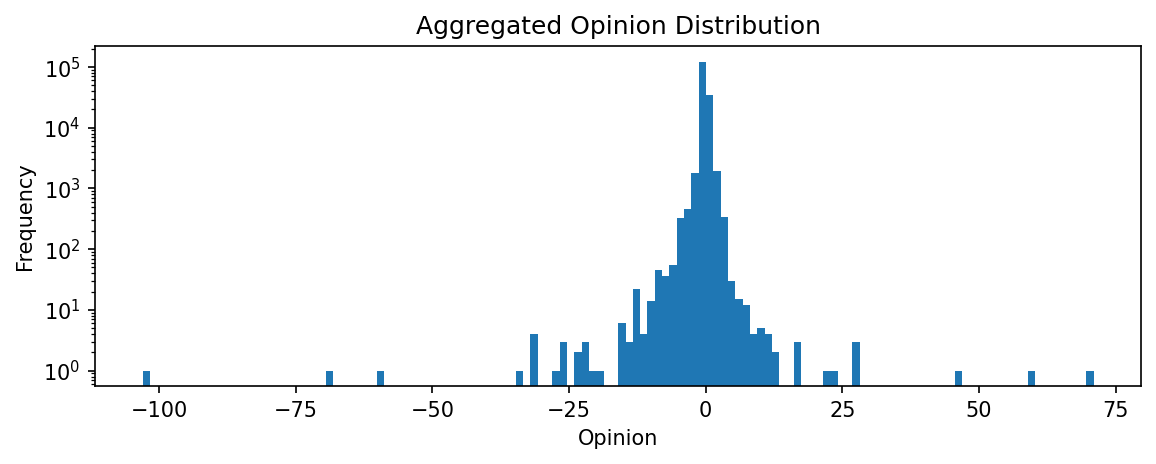

In [78]:
# Plot opinion distribution 
opinion_sequence=list(opinion_dict.values())
plt.figure(figsize=(9,3), dpi=150)
plt.hist(opinion_sequence, bins=130)
plt.xlabel("Opinion")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Aggregated Opinion Distribution")
plt.show()

## Networks

### Network Construction

In [24]:
# Create tweet-hashtag bipartite network
tweet_hashtag_network=nx.Graph()
tweet_hashtag_network.name="Tweet-Hashtag Bipartite Network"
tweet_hashtag_network.add_nodes_from([i for i in range(len(hashtag_collection))], bipartite=0)
tweet_hashtag_network.add_nodes_from(hashtag_list, bipartite=1)
tweet_hashtag_network.add_edges_from([(i, hasht) for i,hash_coll in enumerate(hashtag_collection) for hasht in hash_coll], weight=1)
print(nx.info(tweet_hashtag_network))

Name: Tweet-Hashtag Bipartite Network
Type: Graph
Number of nodes: 160044
Number of edges: 169526
Average degree:   2.1185


In [28]:
# Extract the hashtag co-occurence network (weighted unipartite projection)
hashtag_cooccurrence_network=nx.bipartite.weighted_projected_graph(tweet_hashtag_network, hashtag_list)
hashtag_cooccurrence_network.name="Hashtag Co-occurence Network"
# Assign node degree metadata
nx.set_node_attributes(hashtag_cooccurrence_network, {node:hashtag_cooccurrence_network.degree(node, weight="weight") for node in hashtag_cooccurrence_network.nodes()}, "degree")
# Assign node polarity metadata
nx.set_node_attributes(hashtag_cooccurrence_network, polarity_dict, "polarity")
print(nx.info(hashtag_cooccurrence_network))
#list(hashtag_cooccurrence_network.edges(data=True))

Name: Hashtag Co-occurence Network
Type: Graph
Number of nodes: 6211
Number of edges: 3438
Average degree:   1.1071


### Hashtag Co-occurence Matrix

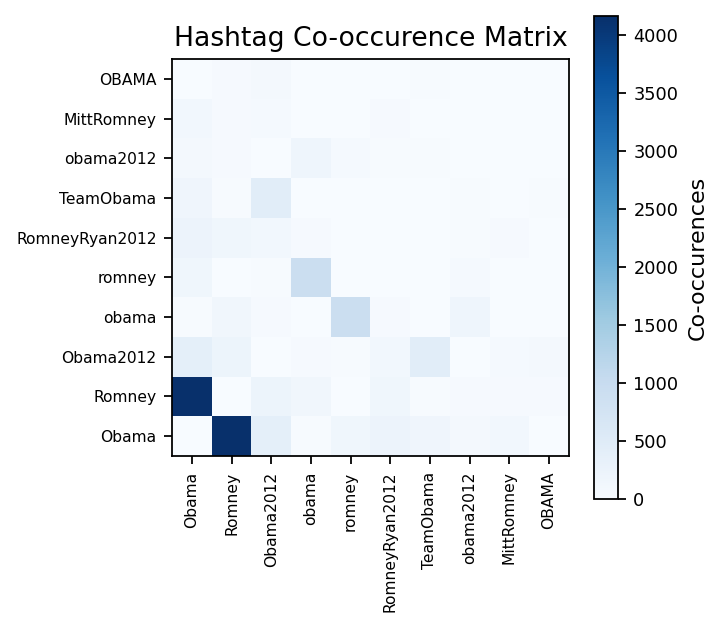

In [72]:
# Plot co-occurence distribution
relevant_hashtags=hashtag_names_cooccurrence[:10]
plt.figure(figsize=(4,4), dpi=160)
plt.imshow(nx.to_numpy_matrix(hashtag_cooccurrence_network, nodelist=relevant_hashtags),cmap="Blues", origin="lower")
#plt.xlabel("Hashtag")
#plt.ylabel("Hashtag")
plt.xticks(ticks=range(len(relevant_hashtags)), labels =relevant_hashtags ,size=7, rotation=90)
plt.yticks(ticks=range(len(relevant_hashtags)),labels =relevant_hashtags ,size=7)
cb=plt.colorbar(label="Co-occurences") #,shrink=1)
cb.ax.tick_params(labelsize=8)
#plt.legend(fontsize=1)
plt.title("Hashtag Co-occurence Matrix")
#plt.savefig("/Users/Pit/GitHub/Econophysics/Project/TwitterMonitor/EconophysicsInitialization/notebooks/CooccurenceHashtagMatrix.png", dpi=200)
plt.show()

### Degree Distribution

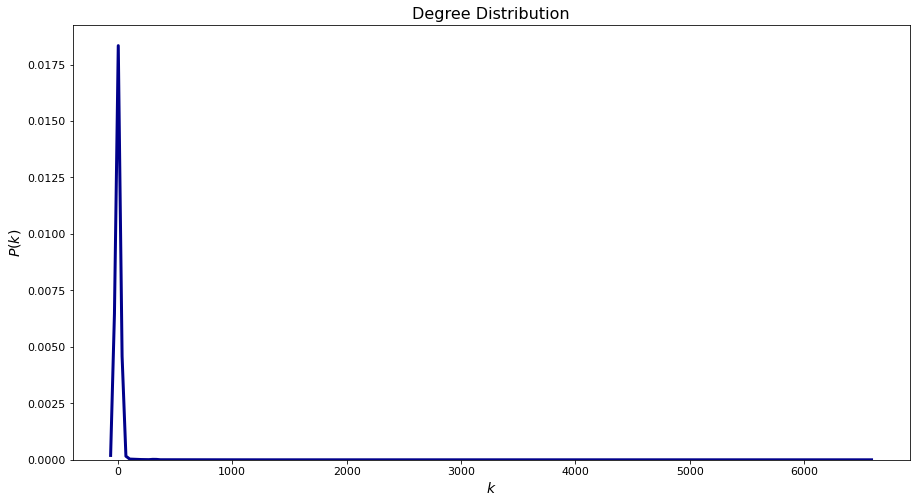

In [80]:
Ec.plot_distribution_from_view(dict(hashtag_cooccurrence_network.degree(weight="weight")),
                               hist=False,
                               bins=1000,
                               title="Degree Distribution", 
                               log=False, 
                               display_stats=True,
                               #kde_kws={"bw":0.5}
                               ) #kde_kws={"bw":1.5} if complains about bandwidth & plot is blank

### Power Law 

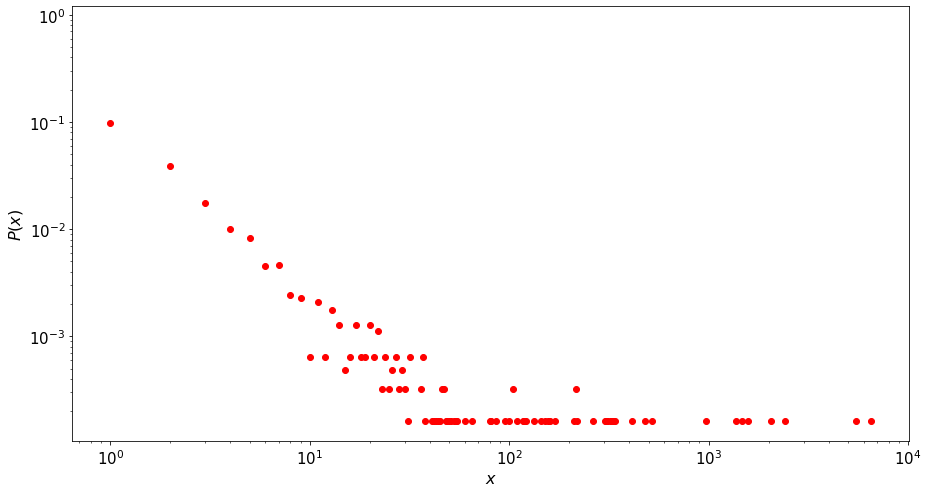

In [81]:
pwl_distribution=Ec.power_law_plot(view=dict(hashtag_cooccurrence_network.degree(weight="weight")), log=True, linear_binning=False, bins=1000, draw=True, rounding =2)

### Assortativity Analysis

Degree Assortativity Coefficient: -0.3686446663531886
k_unc =  2637.310614716636


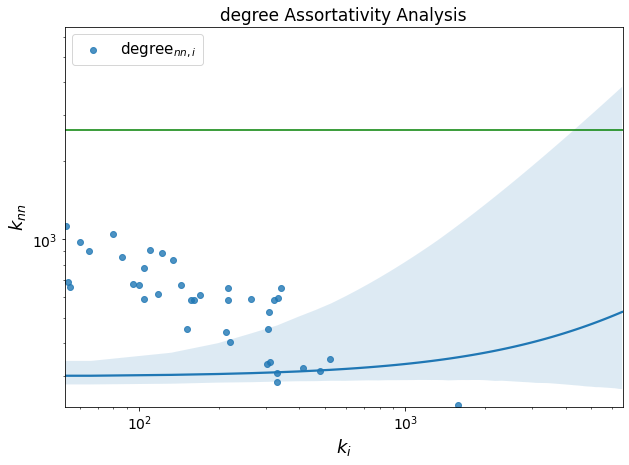

In [79]:
# Degree Assortativity
hashtag_cooccurrence_DAC=nx.degree_assortativity_coefficient(hashtag_cooccurrence_network)
print("Degree Assortativity Coefficient:",hashtag_cooccurrence_DAC)
Ec.get_assortativity(hashtag_cooccurrence_network, "degree", x_log=True,y_log=True, direction="both", extremists_tolerance=None, outliers_tolerance=None)

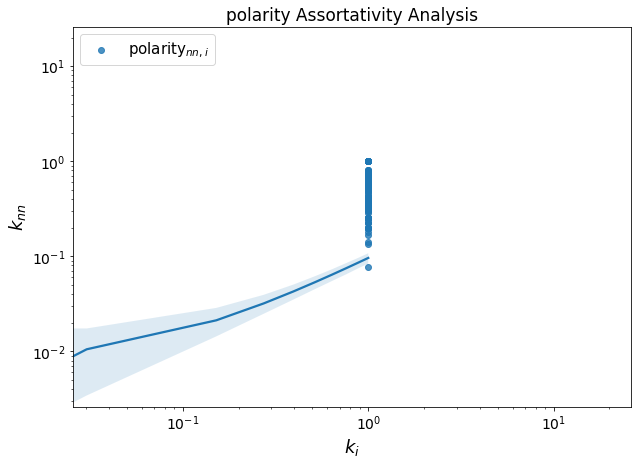

In [44]:
# Polarity Assortativity
Ec.get_assortativity(hashtag_cooccurrence_network, "polarity", x_log=True,y_log=True, direction="both", extremists_tolerance=None, outliers_tolerance=None)

# Last three 2012 months analysis

## Data extraction
Since the monitor ran for 25 days, 17 before the election day and 7 after, and since 2012 elections were on November 6-th, we will read the processed archiveTeam files from 20-10-2012 to 13-11-2012. 

In [2]:
# utilty functions
def utc_s(): #https://stackoverflow.com/questions/5998245/get-current-time-in-milliseconds-in-python
    return round(datetime.utcnow().timestamp()) + (60*60*2)

def get_date_from_str(date_str, as_string = False):
    frmt = "%a %b %d %H:%M:%S %Y" #"%a %b %d %H:%M:%S %z %Y"
    date_str = date_str[:19]+date_str[25:]
    DateTime = datetime.strptime(date_str,frmt)
    if not as_string:
        return DateTime
    else:
        return str(DateTime)
    

def get_lists_indices(series):
    return [type(elem) != list for elem in series  ]



def select_by_hashtags(series):
    return [not set([hashtag.lower() for hashtag in lst]).isdisjoint(hashtags) for lst in series]

def select_by_users(series, ids):
    return [user_id in ids for user_id in series]

Uncomment this to retrieve data during the election period

In [30]:
# #only 25 days
# october_folder = r"F:\TwitterUsers\saved_objs_withKeywords\10\\"
# november_folder = r"F:\TwitterUsers\saved_objs_withKeywords\11\\"

# october_all_days = Ec.get_listOfFiles(october_folder)
# november_all_days = Ec.get_listOfFiles(november_folder)


# october_interesting_days = []
# november_interesting_days = []
# for i in range(len(october_all_days)):
#     if int(october_all_days[i][october_all_days[i].rfind("objs_")+len("objs_"):october_all_days[i].rfind(".txt")]) >= 19:
#         october_interesting_days.append(october_all_days[i])
        

# for i in range(len(november_all_days)):
#     if int(november_all_days[i][november_all_days[i].rfind("objs_")+len("objs_"):november_all_days[i].rfind(".txt")]) <= 12:
#         november_interesting_days.append(november_all_days[i])
        
# interesting_days = october_interesting_days + november_interesting_days
# total = len(interesting_days)
# print(total)

25


Uncomment this to retrieve data during october and november

In [76]:
# # october and november
# october_folder = r"F:\TwitterUsers\saved_objs_withKeywords\10\\"
# november_folder = r"F:\TwitterUsers\saved_objs_withKeywords\11\\"

# october_all_days = Ec.get_listOfFiles(october_folder)
# november_all_days = Ec.get_listOfFiles(november_folder)

# interesting_days = october_all_days + november_all_days
# total = len(interesting_days)

Uncomment this to retrieve data during the whole year

In [8]:
#interesting_days

In [12]:
# entire year
## Archiveteam
interesting_days = Ec.get_listOfFiles(r"F:\TwitterUsers\saved_objs_withKeywords")
total = len(interesting_days)
print(total)

##38M
# interesting_days = Ec.get_listOfFiles(r"D:\TwitterUsers\archiveTeam\final_analysis\hydration\hydrated\threading_objs")
# total = len(interesting_days)
# print(total)

330


In [7]:
# # load ids of moniotred users
# monitored_users_objects = np.load(r"D:\TwitterUsers\archiveTeam\monitor\initial_monitor_objs\archiveTeam_initial_monitor_objs.npy", allow_pickle = True)
# users_ids = set([user["user_id"] for user in monitored_users_objects ])

#load ids of ok_users
users_ids = set(Ec.pickle_loader("F:\TwitterUsers\processed_files\AT_thread_output\ok_users.txt"))
print(len(users_ids))

161559


In [8]:
# load selected hashtags
hashtags = []
with open(r"E:\IlMioDrive\magistrale\1anno\terzo_periodo\MAS\temp\hashtags\hashtags_1_filtered.txt","rb") as f:
    hashtags = set(pickle.load(f))
    f.close()
len(hashtags)

6948

In [10]:
# create final list of dicts
main_lst =[]
for user in users_ids:
    user_dct  = dict()
    user_dct["user_id"] = user
    user_dct["retweeted_users_ids"] = []
    user_dct["hashtags"] = []
    user_dct["user_mentions"] = []
    user_dct["followers_count"] = []
    user_dct["friends_count"] = []
    user_dct["statuses_count"] = []
    user_dct["favourites_count"] = []
    user_dct["friend_activity"] = 0
    user_dct["follower_activity"] = 0
    user_dct["favourite_activity"] = 0
    user_dct["hashtag_activity"] = 0
    user_dct["mention_activity"] = 0
    user_dct["retweet_activity"] = 0
    user_dct["tweet_activity"] = 0
    main_lst.append(user_dct)

In [13]:
%%time
# read the files and store data
# start_date = datetime.strptime("2012-10-20 00:00:00" , "%Y-%m-%d %H:%M:%S") 
# stop_date = datetime.strptime("2012-11-11 23:59:59" , "%Y-%m-%d %H:%M:%S") 
#added = 0
errors = []
total_mentions = 0
for i, path in enumerate(interesting_days):
    with open(path,"rb") as f:
        day_csv = pd.DataFrame(pickle.load(f)).drop( labels = ["text"], axis  = 1)
        f.close()
    day_csv = day_csv[select_by_users(day_csv["user_id"], users_ids)]
    day_csv= day_csv[ get_lists_indices(day_csv["tweet_id"])]
    day_csv["tweet_created_at"] = [get_date_from_str(date) for date in day_csv["tweet_created_at"] ]
    
    day_lst = day_csv.to_dict("records")
    del day_csv
    for tweet in day_lst:
        dct = next((item for item in main_lst if item['user_id'] == tweet["user_id"]), None)
        try:
            tweet_date  = tweet["tweet_created_at"]
            #if tweet_date >= start_date and tweet_date <= stop_date:
            dct["retweeted_users_ids"].append( (tweet["retweeted_user_id"],tweet_date) )
            dct["hashtags"].extend([ (hasht, tweet_date) for hasht in tweet["hashtags"] if hasht in hashtags])
            dct["user_mentions"].extend([ (ment, tweet_date) for ment in tweet["user_mentions"] ])
            dct["followers_count"].append( (tweet["followers_count"], tweet_date) )
            dct["friends_count"].append( (tweet["friends_count"], tweet_date) )
            dct["statuses_count"].append( (tweet["statuses_count"], tweet_date) )
            dct["favourites_count"].append( (tweet["favourites_count"], tweet_date) )

            retweet_activity = 0
            tweet_activity = 0
            dct["friend_activity"]  = sum([abs(dct["friends_count"][i+1][0]-dct["friends_count"][i][0]) for i in range(len(dct["friends_count"])-1)])#sum([abs(x[0]-dct["friends_count"][i-1][0]) for i,x in enumerate(dct["friends_count"][1:])])
            dct["follower_activity"]  = sum([abs(dct["followers_count"][i+1][0]-dct["followers_count"][i][0]) for i in range(len(dct["followers_count"])-1)])
            dct["favourite_activity"]  = sum([abs(dct["favourites_count"][i+1][0]-dct["favourites_count"][i][0]) for i in range(len(dct["favourites_count"])-1)])
            dct["hashtag_activity"] = len(dct["hashtags"])
            dct["mention_activity"] = len(dct["user_mentions"])
            for act in dct["retweeted_users_ids"]:
                if act[0] != []:
                    retweet_activity += 1
                else:
                    tweet_activity += 1
            dct["retweet_activity"] = retweet_activity
            dct["tweet_activity"] = tweet_activity
            total_mentions +=  dct["mention_activity"] 
        except KeyError as e:
            errors.append(tweet)
            print(e, end = "\r")
            continue
        except Exception:
            print("exception at i = ", i, "path = ", path)
            raise e
    print("Done", i, "out of",total,"total mentions = ",total_mentions,"file = ",path,end = "\r")



Wall time: 1d 14h 49min 59sentions =  842843272 file =  F:\TwitterUsers\saved_objs_withKeywords\11\objs_9.txtt


In [15]:
main_lst

[{'user_id': 122159104,
  'retweeted_users_ids': [],
  'hashtags': [],
  'user_mentions': [],
  'followers_count': [],
  'friends_count': [],
  'statuses_count': [],
  'favourites_count': [],
  'friend_activity': 0,
  'follower_activity': 0,
  'favourite_activity': 0,
  'hashtag_activity': 0,
  'mention_activity': 0},
 {'user_id': 331350017,
  'retweeted_users_ids': [([], Timestamp('2012-10-26 20:49:26')),
   (182053057, Timestamp('2012-10-28 02:39:31')),
   ([], Timestamp('2012-10-29 15:46:32')),
   ([], Timestamp('2012-10-29 20:37:34')),
   ([], Timestamp('2012-11-01 19:34:35')),
   ([], Timestamp('2012-11-02 13:05:46')),
   ([], Timestamp('2012-11-05 15:10:54')),
   ([], Timestamp('2012-11-07 02:46:58')),
   ([], Timestamp('2012-11-07 03:17:27'))],
  'hashtags': [('TeamObama', Timestamp('2012-11-07 03:17:27'))],
  'user_mentions': [(182053057, Timestamp('2012-10-28 02:39:31')),
   (250000644, Timestamp('2012-10-29 20:37:34')),
   (242030666, Timestamp('2012-11-01 19:34:35')),
   (40

In [15]:
with open(r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\monitored_users_2012_AT_activity_160000.txt", "wb") as f:
    pickle.dump(main_lst,f)
    f.close()

Unify period-corresponding AT and 38M processed datasets.

In [14]:
#year
year_AT = Ec.pickle_loader(r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\monitored_users_2012_AT_activity.txt")
year_38M = Ec.pickle_loader(r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\monitored_users_2012_38M_activity.txt")

#election_period

In [63]:
# create final list of dicts
final_lst =[]
for user in monitored_users_ids:
    user_dct  = dict()
    user_dct["user_id"] = user
    user_dct["retweeted_users_ids"] = []
    user_dct["hashtags"] = []
    user_dct["user_mentions"] = []
    user_dct["followers_count"] = []
    user_dct["friends_count"] = []
    user_dct["statuses_count"] = []
    user_dct["favourites_count"] = []
    final_lst.append(user_dct)

In [66]:
for dct_AT in year_AT:
    dct_38M = next((item for item in year_38M if item['user_id'] == dct_AT["user_id"]), None)
    dct = next((item for item in final_lst if item['user_id'] == dct_AT["user_id"]), None)
    
    dct["retweeted_users_ids"].extend(dct_AT["retweeted_users_ids"])
    #dct["retweeted_users_ids"].extend(dct_38M["retweeted_users_ids"])
    dct["retweeted_users_ids"].extend([temp for temp in  dct_38M["retweeted_users_ids"] if temp not in  dct["retweeted_users_ids"]])
    
    dct["hashtags"].extend(dct_AT["hashtags"])
    dct["hashtags"].extend([temp for temp in  dct_38M["hashtags"] if temp not in  dct["hashtags"]])
    
    dct["user_mentions"].extend(dct_AT["user_mentions"])
    dct["user_mentions"].extend([temp for temp in  dct_38M["user_mentions"] if temp not in  dct["user_mentions"]])
    
    dct["followers_count"].extend(dct_AT["followers_count"])
    dct["followers_count"].extend([temp for temp in  dct_38M["followers_count"] if temp not in  dct["followers_count"]])
    
    dct["friends_count"].extend(dct_AT["friends_count"])
    dct["friends_count"].extend([temp for temp in  dct_38M["friends_count"] if temp not in  dct["friends_count"]])
    
    dct["statuses_count"].extend(dct_AT["statuses_count"])
    dct["statuses_count"].extend([temp for temp in  dct_38M["statuses_count"] if temp not in  dct["statuses_count"]])
    
    dct["favourites_count"].extend(dct_AT["favourites_count"])
    dct["favourites_count"].extend([temp for temp in  dct_38M["favourites_count"] if temp not in  dct["favourites_count"]])
    
    
    retweet_activity = 0
    tweet_activity = 0
    dct["friend_activity"]  = sum([abs(dct["friends_count"][i+1][0]-dct["friends_count"][i][0]) for i in range(len(dct["friends_count"])-1)])#sum([abs(x[0]-dct["friends_count"][i-1][0]) for i,x in enumerate(dct["friends_count"][1:])])
    dct["follower_activity"]  = sum([abs(dct["followers_count"][i+1][0]-dct["followers_count"][i][0]) for i in range(len(dct["followers_count"])-1)])
    dct["favourite_activity"]  = sum([abs(dct["favourites_count"][i+1][0]-dct["favourites_count"][i][0]) for i in range(len(dct["favourites_count"])-1)])
    dct["hashtag_activity"] = len(dct["hashtags"])
    dct["mention_activity"] = len(dct["user_mentions"])
    for act in dct["retweeted_users_ids"]:
        if act[0] != []:
            retweet_activity += 1
        else:
            tweet_activity += 1
    dct["retweet_activity"] = retweet_activity
    dct["tweet_activity"] = tweet_activity

In [71]:
Ec.pickle_dumper(r"D:\TwitterUsers\archiveTeam\final_analysis\hashtags\2012_hahstag_coocurrence_network\monitored_users_2012_combined_activity.txt",final_lst)

## get hashtagged tweets

Past (unsuccessfull) attempt with dictionaries.
```python
%%time

main_dct = dict()
for user in monitored_users_ids:
    main_dct[user]  = dict()
    main_dct[user]["retweeted_users_ids"] = []
    main_dct[user]["hashtags"] = []
    main_dct[user]["user_mentions"] = []
    main_dct[user]["followers_count"] = []
    main_dct[user]["friends_count"] = []
    main_dct[user]["statuses_count"] = []
    main_dct[user]["favourites_count"] = []
    
start_date = datetime.strptime("2012-10-20 00:00:00" , "%Y-%m-%d %H:%M:%S") 
stop_date = datetime.strptime("2012-11-11 23:59:59" , "%Y-%m-%d %H:%M:%S") 

for i, path in enumerate(interesting_days):
    with open(path,"rb") as f:
        day_csv = pd.DataFrame(pickle.load(f)).drop( labels = ["text"], axis  = 1)
        f.close()
    day_csv= day_csv[ get_lists_indices(day_csv["tweet_id"])]
    day_csv["tweet_created_at"] = [get_date_from_str(date) for date in day_csv["tweet_created_at"] ]
    day_csv = day_csv[select_by_users(day_csv["user_id"], set(monitored_users_ids))]
    day_lst = day_csv.to_dict("records")
    del day_csv
    for tweet in day_lst:
        dct = main_dct[ tweet["user_id"] ]
        tweet_date  = tweet["tweet_created_at"]
        if tweet_date >= start_date and tweet_date <= end_date:
            dct["retweeted_users_ids"].append( (tweet["retweeted_user_id"],tweet_date) )
            dct["hashtags"].extend([ (hasht, tweet_date) for hasht in tweet["hashtags"] if hasht in hashtags])
            dct["user_mentions"].extend([ (ment, tweet_date) for ment in tweet["user_mentions"] ])
            dct["followers_count"].append( (tweet["followers_count"], tweet_date) )
            dct["friends_count"].append( (tweet["friends_count"], tweet_date) )
            dct["statuses_count"].append( (tweet["statuses_count"], tweet_date) )
            dct["favourites_count"].append( (tweet["favourites_count"], tweet_date) )
    print("Done", i, "out of", total, end = "\r")
```
        
                                     